
[Hold-out Forest] Total guest nights | rows=37

[Hold-out Forest] International guest nights | rows=37

[Hold-out Forest] Domestic guest nights | rows=37

[Hold-out] 2024-07-31 → 2025-06-30

Total guest nights
  RMSE : 1,916,087.309
  MAE  : 1,602,837.847
  MAPE : 12.084%
  sMAPE: 12.029%

International guest nights
  RMSE : 1,005,410.270
  MAE  : 820,880.429
  MAPE : 20.456%
  sMAPE: 19.360%

Domestic guest nights
  RMSE : 1,334,906.818
  MAE  : 1,062,161.804
  MAPE : 11.948%
  sMAPE: 11.882%

[Full-fit Forest] Total guest nights | rows=49

[Full-fit Forest] International guest nights | rows=49

[Full-fit Forest] Domestic guest nights | rows=49

Forecast results saved to: ../output/Model_02_Forest_ADP.csv


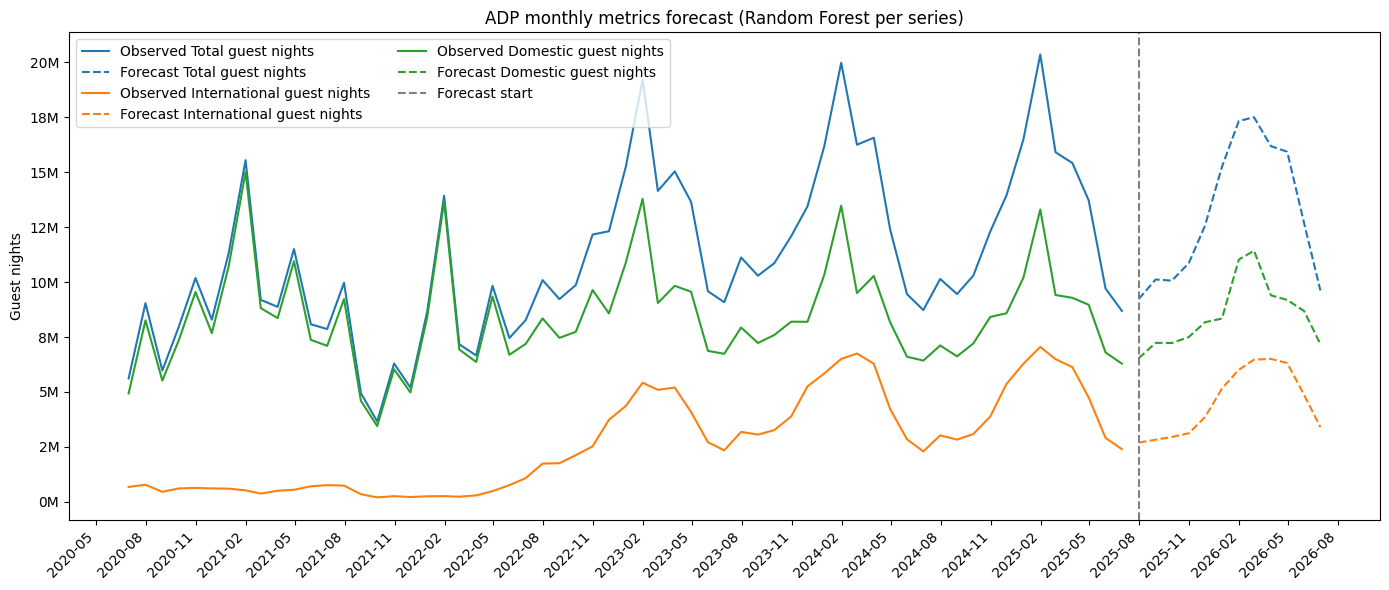

In [1]:
# model_04_forest_adp.py
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from pandas.tseries.offsets import MonthEnd

# ---------------- sklearn ----------------
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----------------------- Config -----------------------
ADP_CSV = "../datasets/ADP_All_Measures.csv"

HORIZON = 12
HOLDOUT_STEPS = 12

SERIES = [
    "Total guest nights",
    "International guest nights",
    "Domestic guest nights",
]

# RandomForest hyperparameters (tune if needed)
RF_PARAMS = dict(
    n_estimators=800,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

# Feature lags
MAX_LAG = 12      # y_lag1..y_lag12
SEASONAL_LAG = 12 # y_lag12 acts as seasonal lag

# ----------------------- Helpers -----------------------
def full_month_range(idx):
    start = pd.to_datetime(idx.min()) + MonthEnd(0)
    end = pd.to_datetime(idx.max()) + MonthEnd(0)
    return pd.date_range(start=start, end=end, freq="ME")

def configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def print_banner(s):
    bar = "=" * len(s)
    print(f"\n{bar}\n{s}\n{bar}")

# ----------------------- Load & Aggregate ADP -----------------------
def load_adp_national(adp_csv: str) -> pd.DataFrame:
    adp = pd.read_csv(adp_csv)
    adp["Month"] = pd.to_datetime(adp["Month"], format="%Y-%m-%d", errors="coerce")
    adp["Date"] = adp["Month"] + MonthEnd(0)

    if "Total guest nights" not in adp.columns:
        if {"Domestic guest nights", "International guest nights"}.issubset(adp.columns):
            adp["Total guest nights"] = (
                adp["Domestic guest nights"] + adp["International guest nights"]
            )
        else:
            raise ValueError("Missing both 'Total guest nights' and components to construct it.")

    g = adp.groupby("Date")[SERIES].sum(min_count=1).sort_index()
    idx = full_month_range(g.index)
    g = g.reindex(idx).ffill().bfill()

    return g

# ----------------------- Transformations -----------------------
def forward_transform(df: pd.DataFrame):
    """
    Log1p + standardize per series (like your VAR pipeline).
    We model on the standardized log space and invert later.
    """
    z = np.log1p(df.clip(lower=0))
    mu, sd = z.mean(), z.std(ddof=0).replace(0, 1.0)
    z_std = (z - mu) / sd
    return z_std, {"mu": mu, "sd": sd}

def inverse_transform(z_std: pd.DataFrame, meta: dict):
    z = z_std * meta["sd"] + meta["mu"]
    return np.expm1(z).clip(lower=0)

# ----------------------- Metrics -----------------------
def _rmse(a, f):
    return float(np.sqrt(np.mean((np.asarray(a, float) - np.asarray(f, float)) ** 2)))

def _mae(a, f):
    return float(np.mean(np.abs(np.asarray(a, float) - np.asarray(f, float))))

def _mape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    mask = a != 0
    return float(np.mean(np.abs((a[mask] - f[mask]) / a[mask])) * 100) if mask.any() else np.nan

def _smape(a, f):
    a, f = np.asarray(a, float), np.asarray(f, float)
    denom = np.abs(a) + np.abs(f)
    mask = denom != 0
    return float(np.mean(2 * np.abs(a[mask] - f[mask]) / denom[mask]) * 100) if mask.any() else np.nan

def print_metrics_block(title, actual: pd.Series, forecast: pd.Series):
    print_banner(title)
    print(f"  RMSE : {_rmse(actual, forecast):,.3f}")
    print(f"  MAE  : {_mae(actual, forecast):,.3f}")
    print(f"  MAPE : {_mape(actual, forecast):.3f}%")
    print(f"  sMAPE: {_smape(actual, forecast):.3f}%")

# ----------------------- Feature engineering -----------------------
def make_design_matrix_1d(z: pd.Series, max_lag: int = MAX_LAG) -> pd.DataFrame:
    """
    Build supervised matrix for a single standardized log series z:
      y (current), y_lag1..y_lag{max_lag}, month (1..12), trend.
    Rows with NA (due to lags) are dropped.
    """
    df = pd.DataFrame({"y": z.copy()})
    for L in range(1, max_lag + 1):
        df[f"y_lag{L}"] = z.shift(L)
    df["month"] = df.index.month.astype("int8")
    df["trend"] = np.arange(len(df), dtype="int32")
    return df.dropna().copy()

def fit_rf(X_train: pd.DataFrame, y_train: pd.Series) -> Pipeline:
    cat_cols = ["month"]
    num_cols = [c for c in X_train.columns if c not in cat_cols]
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    model = RandomForestRegressor(**RF_PARAMS)
    pipe = Pipeline(steps=[("prep", pre), ("rf", model)])
    pipe.fit(X_train, y_train)
    return pipe

def recursive_predict_1d(pipe: Pipeline, last_row: pd.Series, steps: int, start_next: pd.Timestamp) -> pd.Series:
    """
    Roll forward 'steps' months recursively for a single series.
    `last_row` is the last available design-matrix row (with all lag features).
    We update month/trend and shift lag features using the previous prediction.
    Returns a Series indexed by monthly dates starting at `start_next`.
    """
    preds = []
    curr = last_row.copy()
    idxs = pd.date_range(start_next, periods=steps, freq="ME")

    # Determine max lag present
    max_lag = max(int(c.split("y_lag")[1]) for c in curr.index if c.startswith("y_lag"))

    for t in idxs:
        # calendar features
        curr["month"] = t.month
        curr["trend"] = int(curr["trend"]) + 1

        # predict
        X_one = curr.drop(labels=["y"], errors="ignore").to_frame().T
        y_hat = float(pipe.predict(X_one)[0])
        preds.append((t, y_hat))

        # shift lags: y_lagK <- y_lag(K-1), ..., y_lag1 <- y_hat
        for L in range(max_lag, 1, -1):
            curr[f"y_lag{L}"] = curr[f"y_lag{L-1}"]
        curr["y_lag1"] = y_hat
        curr["y"] = y_hat

    return pd.Series(dict(preds))

# ----------------------- Hold-out evaluation -----------------------
def evaluate_holdout_forest(g: pd.DataFrame, holdout_steps: int = HOLDOUT_STEPS):
    """
    Train on history up to -holdout_steps, compute OOS metrics on the holdout window
    with recursive multi-step prediction in standardized log space, then back-transform.
    """
    if len(g) < (holdout_steps + 36):
        holdout_steps = max(6, len(g) - 36)
    if holdout_steps <= 0:
        return

    train_g, test_g = g.iloc[:-holdout_steps], g.iloc[-holdout_steps:]
    z_train, meta_train = forward_transform(train_g)

    mu_test_std = pd.DataFrame(index=test_g.index, columns=SERIES, dtype="float64")

    start_next = train_g.index[-1] + MonthEnd(1)

    for col in SERIES:
        # Supervised data for the target series
        dm = make_design_matrix_1d(z_train[col], MAX_LAG)
        # last available row *before* the holdout start to seed recursion
        last_idx = dm.index[dm.index < start_next].max()
        last_row = dm.loc[last_idx].copy()

        # Fit
        X_train = dm.drop(columns=["y"])
        y_train = dm["y"]
        pipe = fit_rf(X_train, y_train)

        # Recursive prediction on the holdout window
        mu_std = recursive_predict_1d(pipe, last_row, steps=holdout_steps, start_next=start_next)
        mu_test_std[col] = mu_std

        print_banner(f"[Hold-out Forest] {col} | rows={len(dm):d}")

    # Back to level space and compute metrics
    fc_test_levels = inverse_transform(mu_test_std, meta_train)

    print_banner(f"[Hold-out] {test_g.index[0].date()} → {test_g.index[-1].date()}")
    for col in SERIES:
        print_metrics_block(col, test_g[col], fc_test_levels[col])

# ----------------------- Full-fit & future forecast -----------------------
def fit_full_and_forecast_forest(g: pd.DataFrame, horizon: int = HORIZON):
    """
    Fit on the full history and forecast 'horizon' months recursively, per series.
    Returns a DataFrame of level forecasts (no CIs for RF).
    """
    z_full, meta_full = forward_transform(g)
    start_next = g.index[-1] + MonthEnd(1)

    mu_future_std = pd.DataFrame(
        index=pd.date_range(start_next, periods=horizon, freq="ME"),
        columns=SERIES,
        dtype="float64",
    )

    for col in SERIES:
        dm = make_design_matrix_1d(z_full[col], MAX_LAG)
        last_row = dm.iloc[-1].copy()

        X = dm.drop(columns=["y"])
        y = dm["y"]
        pipe = fit_rf(X, y)

        mu_std = recursive_predict_1d(pipe, last_row, steps=horizon, start_next=start_next)
        mu_future_std[col] = mu_std

        print_banner(f"[Full-fit Forest] {col} | rows={len(dm):d}")

    fc_levels = inverse_transform(mu_future_std, meta_full)
    return fc_levels

# ----------------------- Main -----------------------
def main():
    g = load_adp_national(ADP_CSV)

    # Holdout performance
    evaluate_holdout_forest(g, holdout_steps=HOLDOUT_STEPS)

    # Fit on full data & forecast
    fc_levels = fit_full_and_forecast_forest(g, HORIZON)

    start_fc = fc_levels.index[0]
    observed = g.copy()

    # ---------------- Save forecast results ----------------
    out_csv = "../output/Model_02_Forest_ADP.csv"
    out = fc_levels.copy()
    out.index.name = "Date"
    out.round(0).astype(int).to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    # ---------------- Combined plot ----------------
    plt.figure(figsize=(14, 6))
    colors = {
        "Total guest nights": "#1f77b4",
        "International guest nights": "#ff7f0e",
        "Domestic guest nights": "#2ca02c",
    }
    for col in SERIES:
        plt.plot(observed.index, observed[col], label=f"Observed {col}", color=colors[col])
        plt.plot(fc_levels.index, fc_levels[col], linestyle="--", label=f"Forecast {col}", color=colors[col])

    plt.axvline(start_fc, color="gray", linestyle="--", label="Forecast start")
    plt.title("ADP monthly metrics forecast (Random Forest per series)")
    plt.ylabel("Guest nights")
    plt.legend(loc="upper left", ncol=2, frameon=True)
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x*1e-6:,.0f}M"))
    configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
